# Introduction to Adversarial Machine Learning (AML)

## Motivation
Let $f_\theta: \mathcal{X} \to \mathcal{Y}$ be a machine learning model with parameters $\theta$, mapping inputs $x \in \mathcal{X}$ to outputs $y \in \mathcal{Y}$.  

Adversarial Machine Learning (AML) studies the robustness of such models under **intentional manipulation** of inputs. The core problem can be stated as:

$$
\exists \, x' \in \mathcal{X} \quad \text{s.t.} \quad \|x' - x\|_p \leq \epsilon \;\; \wedge \;\; f_\theta(x') \neq f_\theta(x)
$$

where:
- $x'$ is the **adversarial example**,  
- $\epsilon$ is the **perturbation budget** under norm $\|\cdot\|_p$,  
- $f_\theta(x')$ is the misclassified output.  

Thus, adversarial examples exploit the model’s decision boundary in high-dimensional spaces.

---

## Threat Model
Formally, an **adversary’s objective** can be defined by a loss function $L(\theta, x, y)$:

1. **Targeted attack**:  
   $$
   x^\ast = \arg\max_{x' \in \mathcal{B}_\epsilon(x)} \; L(\theta, x', y_t)
   $$  
   where $y_t$ is the attacker’s chosen target label.

2. **Untargeted attack**:  
   $$
   x^\ast = \arg\max_{x' \in \mathcal{B}_\epsilon(x)} \; L(\theta, x', y)
   $$ 
   where $y$ is the true label.  

Here $\mathcal{B}_\epsilon(x) = \{x' : \|x' - x\|_p \leq \epsilon\}$ denotes the **adversarial perturbation set**.

---

## Types of Attacks

- **Evasion attacks (test-time)**  
  Example: *Fast Gradient Sign Method (FGSM)* (Goodfellow et al., 2015)  
  $$
  x' = x + \epsilon \cdot \text{sign} \big( \nabla_x L(\theta, x, y) \big)
  $$

- **Iterative attacks** (PGD, CW):  
  $$
  x^{(t+1)} = \Pi_{\mathcal{B}_\epsilon(x)} \Big( x^{(t)} + \alpha \cdot \text{sign} \big( \nabla_x L(\theta, x^{(t)}, y) \big) \Big)
  $$  
  where $\Pi$ is the projection onto the $\epsilon$-ball.

- **Poisoning attacks (training-time)**: adversary modifies a fraction $\delta$ of the training set $\mathcal{D}$:  
  $$
  \mathcal{D}' = \mathcal{D} \cup \{(x_p, y_p)\}, \quad \text{s.t.} \; f_{\theta'} \; \text{is degraded or biased}
  $$

---

## Defense Strategies

1. **Adversarial training**:  
   Solve a minimax optimization:  
   $$
   \min_\theta \; \mathbb{E}_{(x,y) \sim \mathcal{D}} \; \Big[ \max_{\|x' - x\|_p \leq \epsilon} L(\theta, x', y) \Big]
   $$

2. **Gradient masking / defensive distillation**:  
   Use softened predictions via a temperature parameter $T$:  
   $$
   q_i(x) = \frac{\exp(z_i(x) / T)}{\sum_j \exp(z_j(x) / T)}
   $$  
   where $z_i(x)$ are the logits.

3. **Certified robustness**:  
   Guarantee that no adversarial example exists within radius $\epsilon$:  
   $$
   \forall x' \in \mathcal{B}_\epsilon(x), \quad f_\theta(x') = f_\theta(x)
   $$

---

## Theoretical Insights

- **Linearity in high dimensions**:  
  For a linear classifier $f(x) = \text{sign}(w^\top x)$, a perturbation $\eta = \epsilon \cdot \text{sign}(w)$ satisfies:  
  $$
  f(x+\eta) \neq f(x), \quad \|\eta\|_\infty = \epsilon
  $$

- **Non-robust features hypothesis** (Ilyas et al., 2019):  
  Classifiers rely on a decomposition of features into **robust** ($\mathcal{F}_r$) and **non-robust** ($\mathcal{F}_{nr}$).  
  Adversarial examples exploit $\mathcal{F}_{nr}$ despite human imperceptibility.

- **Trade-off between accuracy and robustness**:  
  $$
  \text{Acc}_{clean}(\theta) + \text{Acc}_{robust}(\theta) \;\; \text{often exhibits a Pareto frontier}
  $$

---

## Relevance for Research and Practice
Adversarial ML reveals that **deep models learn decision boundaries vulnerable to small, structured perturbations**. This is critical in domains such as:
- **Cybersecurity**: adversarial malware examples $x'$ that evade $f_\theta$.  
- **Wireless communication (6G)**: adversarial jamming signals that mislead modulation classifiers.  
- **Autonomous systems**: perturbations $\eta$ on images of road signs that cause misclassification.

Formally, AML bridges **robust optimization**, **information theory**, and **security**—making it a foundational topic for trustworthy AI.

---

## References (Selected)
- Goodfellow et al. (2015): Explaining and Harnessing Adversarial Examples.  
- Madry et al. (2018): Towards Deep Learning Models Resistant to Adversarial Attacks.  
- Carlini & Wagner (2017): Towards Evaluating the Robustness of Neural Networks.  
- Ilyas et al. (2019): Adversarial Examples are Not Bugs, They are Features.  
- Biggio & Roli (2018): Wild Patterns: Ten Years After the Rise of Adversarial Machine Learning.

---


In [1]:
# Core
import os
import copy
import random
import math

# Numerical / ML
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Data handling
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Adversarial robustness
import foolbox as fb

# Evaluation & metrics
from sklearn.metrics import confusion_matrix

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D gradient plots
import seaborn as sns

# Progress bar
from tqdm.notebook import tqdm as tqdm


## $L_p$ Norms and Adversarial Perturbation Balls

A central concept in adversarial machine learning is the definition of a **perturbation set** (also called an *adversarial budget*) that constrains how much the input can be modified.  

This set is typically formalized using **$L_p$ norms**:

$$
\| x' - x \|_p = \left( \sum_{i=1}^d |x'_i - x_i|^p \right)^{1/p}, \quad p \geq 1
$$

where:
- $x \in \mathbb{R}^d$ is the original input,  
- $x' \in \mathbb{R}^d$ is the perturbed (adversarial) input,  
- $d$ is the input dimensionality.  

The **adversarial ball** of radius $\epsilon$ around $x$ is then defined as:

$$
\mathcal{B}_\epsilon^p(x) = \{ x' \in \mathbb{R}^d : \| x' - x \|_p \leq \epsilon \}
$$

This captures all valid adversarial perturbations that an attacker can apply under the $L_p$ constraint.

---

### Common $L_p$ Norms in Adversarial ML

1. **$L_\infty$ norm (max-norm)**  
   $$
   \|x'-x\|_\infty = \max_i |x'_i - x_i|
   $$  
   - Constraint: each pixel/feature can change by at most $\epsilon$.  
   - Popular in image attacks (e.g., FGSM, PGD).  
   - Interpreted as **imperceptible but distributed noise**.

2. **$L_2$ norm (Euclidean norm)**  
   $$
   \|x'-x\|_2 = \sqrt{\sum_i (x'_i - x_i)^2}
   $$  
   - Constraint: overall perturbation energy is bounded.  
   - More perceptible but often more natural perturbations.  
   - Used in Carlini–Wagner ($L_2$) attacks.

3. **$L_1$ norm (Manhattan norm)**  
   $$
   \|x'-x\|_1 = \sum_i |x'_i - x_i|
   $$  
   - Constraint: total absolute change is bounded.  
   - Encourages **sparse perturbations** (few features change significantly).  

4. **$L_0$ “norm” (Hamming distance)**  
   $$
   \|x'-x\|_0 = \#\{ i : x'_i \neq x_i \}
   $$  
   - Counts the number of modified features.  
   - Models attacks where only a few pixels/bits can be changed.  
   - Hard to optimize directly (non-convex).  

---

### Geometric Interpretation
- In **2D**, $L_2$ balls are circles, $L_1$ balls are diamonds, and $L_\infty$ balls are squares.  
- In **high dimensions**, $L_p$ balls behave differently:
  - $L_\infty$: hypercube.  
  - $L_2$: hypersphere.  
  - $L_1$: high-dimensional cross-polytope.  

---

### Relevance for Robustness
Different norms imply different **threat models**:
- $L_\infty$: “imperceptible” noise bounded per pixel/feature.  
- $L_2$: bounded total energy of perturbation.  
- $L_1$: sparse attacks (few but large changes).  
- $L_0$: pixel/bit-level corruption.  

Robustness guarantees are always **norm-dependent**:

$$
\text{A model robust to } L_\infty \text{ attacks may still be vulnerable to } L_2 \text{ or } L_0 \text{ attacks.}
$$


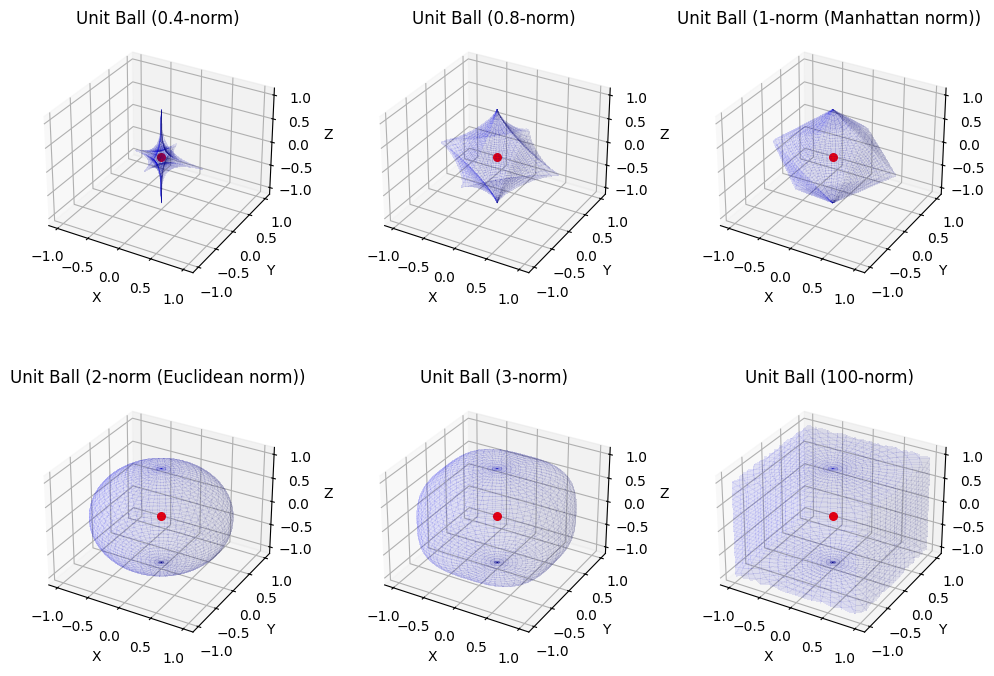

In [2]:
def plot_unit_ball(norm, subplot_index):
    ax = fig.add_subplot(2, 3, subplot_index, projection='3d')  # Adjust the subplot dimensions as needed

    # Generate points on the unit sphere
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))

    # Compute distances from the origin using the specified norm
    distances = np.power(np.power(np.abs(x), norm) + np.power(np.abs(y), norm) + np.power(np.abs(z), norm), 1/norm)

    # Plot the unit ball
    ax.plot_surface(x / distances, y / distances, z / distances, color='b', alpha=0.05, antialiased=False)
    
    # Add a central point 'x'
    ax.scatter([0], [0], [0], color='red', s=30, label='x')

    # Set plot limits and labels based on the figure size
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    max_range = max(max(xlim), max(ylim), max(zlim))
    ax.set_xlim([-max_range, max_range])
    ax.set_ylim([-max_range, max_range])
    ax.set_zlim([-max_range, max_range])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set the title based on the norm used
    if norm == 1:
        norm_name = '1-norm (Manhattan norm)'
    elif norm == 2:
        norm_name = '2-norm (Euclidean norm)'
    elif norm == np.inf:
        norm_name = 'Infinity norm'
    else:
        norm_name = f'{norm}-norm'

    ax.set_title(f'Unit Ball ({norm_name})')

# Create a figure with subplots
fig = plt.figure(figsize=(12, 8))  # Adjust the figure size as needed

# Plot the unit balls as subplots
plot_unit_ball(0.4, 1)  # 0.5-norm
plot_unit_ball(0.8, 2)  # 0.5-norm
plot_unit_ball(1, 3)  # 1-norm (Manhattan norm)
plot_unit_ball(2, 4)  # 2-norm (Euclidean norm)
plot_unit_ball(3, 5)  # 3-norm
plot_unit_ball(100, 6)  # Infinity norm

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.4)  # Adjust the horizontal and vertical spacing as needed

# Show the plot
plt.show()


In [3]:
# Optional: let PyTorch fall back to CPU for unsupported MPS ops
os.environ.setdefault("PYTORCH_ENABLE_MPS_FALLBACK", "1")

# Device: prefer MPS on Apple Silicon, then CUDA, else CPU
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.set_float32_matmul_precision("high")  # small speed boost on modern backends

# -------------------------------
# 1. Dataset (+ 10% validation split)
# -------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_train = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
val_size = int(0.1 * len(full_train))
train_size = len(full_train) - val_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

test_dataset  = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=256, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=256, shuffle=False, num_workers=2)

# -------------------------------
# 2. Model
# -------------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # 28x28 -> 28x28
            nn.ReLU(),
            nn.MaxPool2d(2),                 # 28x28 -> 14x14
            nn.Conv2d(32, 64, 3, padding=1), # 14x14 -> 14x14
            nn.ReLU(),
            nn.MaxPool2d(2),                 # 14x14 -> 7x7
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# -------------------------------
# 3. Training loop with tqdm
# -------------------------------
epochs = 5
for epoch in range(epochs):
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

        loop.set_postfix(loss=loss.item(), acc=f"{100*correct/total:.2f}%")

    # Validation
    model.eval()
    v_correct, v_total, v_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            v_loss += criterion(outputs, labels).item()
            _, preds = outputs.max(1)
            v_total += labels.size(0)
            v_correct += (preds == labels).sum().item()
    print(f"  val_loss: {v_loss/len(val_loader):.4f}  val_acc: {100*v_correct/v_total:.2f}%")

# -------------------------------
# 4. Test
# -------------------------------
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Test Accuracy: {100.0 * correct / total:.2f}%")

# =============================================================================
# Save Model
# =============================================================================
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/mnist_cnn.pth")       # robust
torch.save(model,            "models/mnist_cnn_full.pth")    # convenient
print("Model saved to models/mnist_cnn.pth")


Using device: mps


Epoch 1/5:   0%|          | 0/422 [00:00<?, ?it/s]

  val_loss: 0.0755  val_acc: 97.82%


Epoch 2/5:   0%|          | 0/422 [00:00<?, ?it/s]

  val_loss: 0.0475  val_acc: 98.53%


Epoch 3/5:   0%|          | 0/422 [00:00<?, ?it/s]

  val_loss: 0.0385  val_acc: 98.93%


Epoch 4/5:   0%|          | 0/422 [00:00<?, ?it/s]

  val_loss: 0.0427  val_acc: 98.80%


Epoch 5/5:   0%|          | 0/422 [00:00<?, ?it/s]

  val_loss: 0.0386  val_acc: 98.93%
Test Accuracy: 99.00%
Model saved to models/mnist_cnn.pth


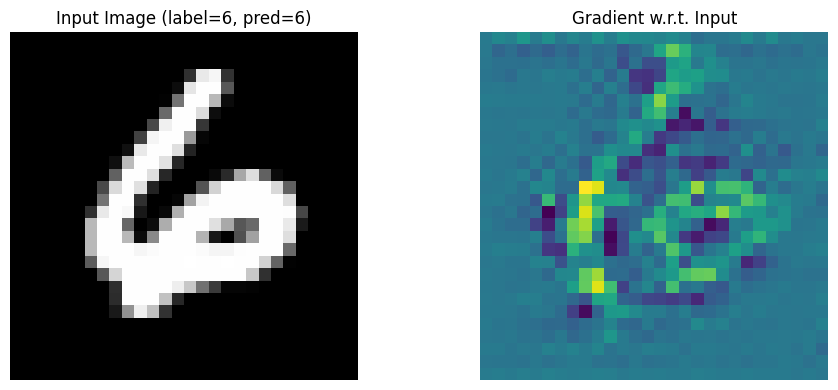

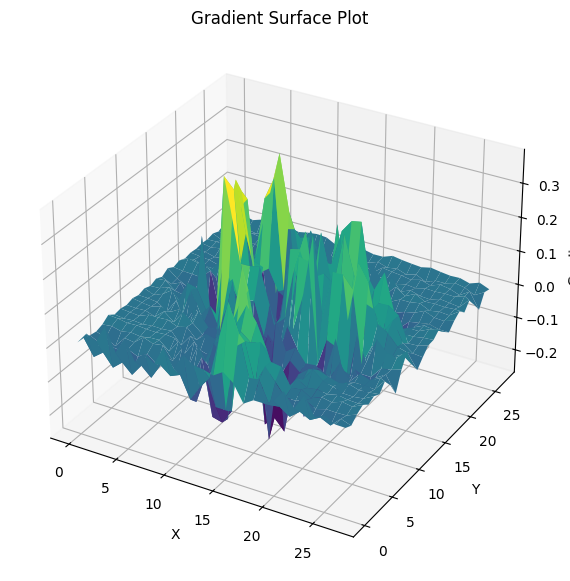

In [4]:
model.eval().to(device)

# ---- pick a random test sample ----
idx = random.randrange(len(test_dataset))
image, label = test_dataset[idx]             # image: [1,28,28] tensor in [-1,1] if normalized
image = image.unsqueeze(0).to(device)        # [1,1,28,28]
image.requires_grad_(True)

# ---- forward + pick predicted class logit ----
with torch.enable_grad():                    # ensure grads on even if eval mode
    logits = model(image)                    # [1,10]
    pred_class = logits.argmax(dim=1).item()
    loss = logits[0, pred_class]             # scalar logit of predicted class

# ---- compute gradient wrt input ----
model.zero_grad(set_to_none=True)
if image.grad is not None:
    image.grad.zero_()
loss.backward()
grad = image.grad                             # [1,1,28,28]

if grad is None:
    print("Gradient is None. Check model and loss.")
else:
    # ---- prepare tensors for display ----
    # De-normalize input for visualization if you used Normalize((0.5,), (0.5,))
    img_disp = image.detach().cpu()[0, 0] * 0.5 + 0.5        # back to ~[0,1]
    grad_disp = grad.detach().cpu()[0, 0]                    # gradient map

    # ---- 2D plots ----
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.imshow(img_disp.numpy(), cmap='gray')
    ax1.set_title(f'Input Image (label={label}, pred={pred_class})')
    ax1.axis('off')
    ax2.imshow(grad_disp.numpy(), cmap='viridis')
    ax2.set_title('Gradient w.r.t. Input')
    ax2.axis('off')
    plt.tight_layout()
    plt.show()

    # ---- 3D surface plot ----
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(np.arange(28), np.arange(28))
    Z = grad_disp.numpy()
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_title('Gradient Surface Plot')
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Gradient')
    plt.show()


Model loaded from state_dict (robust way).


  0%|          | 0/40 [00:00<?, ?it/s]

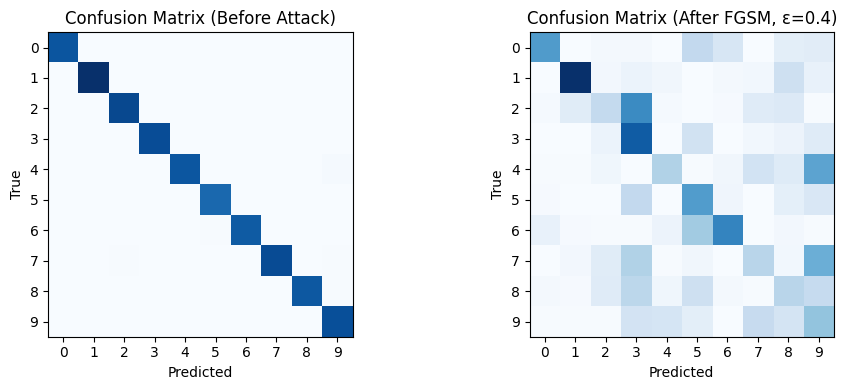

Accuracy before attack: 99.00%
Accuracy after  attack: 40.82%  (epsilon=0.4 in normalized [-1,1] space)


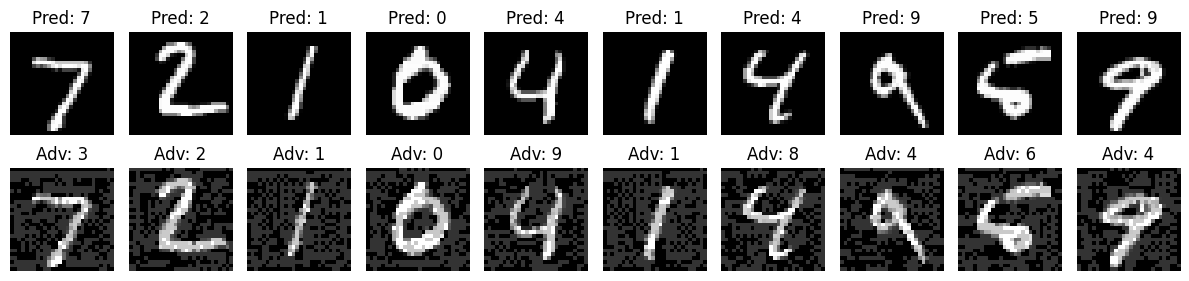

In [5]:
# --- Adversarial evaluation with Foolbox (uses existing variables) ---
# 2. Create model and load weights
model = SimpleCNN().to(device)
state_dict = torch.load("models/mnist_cnn.pth", map_location=device, weights_only=True)
model.load_state_dict(state_dict)

# 3. Switch to eval mode
model.eval()
print("Model loaded from state_dict (robust way).")

# 1) Wrap the existing PyTorch model
model.eval().to(device)
fmodel = fb.PyTorchModel(model, bounds=(-1.0, 1.0), device=device)

# 2) Choose epsilon (normalized space). For epsilon=0.2 in [0,1], use 0.4 here.
epsilon = 0.4  # corresponds to ~0.2 on original [0,1] pixels

attack = fb.attacks.LinfFastGradientAttack()

y_true_all = []
y_pred_before_all = []
y_pred_after_all  = []

orig_images_for_vis = []
adv_images_for_vis  = []
pred_before_vis = []
pred_after_vis  = []

with torch.no_grad():
    # predictions BEFORE attack
    for images, labels in test_loader:
        images = images.to(device)     # already normalized to [-1,1]
        labels = labels.to(device)

        logits = model(images)
        preds  = logits.argmax(1)

        y_true_all.append(labels.cpu())
        y_pred_before_all.append(preds.cpu())

# Now craft adversarials and get AFTER-attack predictions (batch-wise)
for images, labels in tqdm(test_loader):
    images = images.to(device)
    labels = labels.to(device)

    # 3) Generate adversarial examples (FGSM Linf)
    # Foolbox returns (advs, _, success). epsilons can be scalar.
    advs, _, _ = attack(fmodel, images, labels, epsilons=epsilon)

    with torch.no_grad():
        adv_logits = model(advs)
        adv_preds  = adv_logits.argmax(1)

    y_pred_after_all.append(adv_preds.detach().cpu())

    # cache a few examples for visualization
    if len(orig_images_for_vis) < 10:
        take = min(10 - len(orig_images_for_vis), images.size(0))
        orig_images_for_vis.append(images[:take].detach().cpu())
        adv_images_for_vis.append(advs[:take].detach().cpu())
        # For titles, store preds before/after (recompute for the slice)
        with torch.no_grad():
            p_before = model(images[:take]).argmax(1).detach().cpu()
            p_after  = adv_preds[:take].detach().cpu()
        pred_before_vis.append(p_before)
        pred_after_vis.append(p_after)

# 4) Stack and compute confusion matrices
y_true = torch.cat(y_true_all).numpy()
y_pred_before = torch.cat(y_pred_before_all).numpy()
y_pred_after  = torch.cat(y_pred_after_all).numpy()

cm_before = confusion_matrix(y_true, y_pred_before)
cm_after  = confusion_matrix(y_true, y_pred_after)

# 5) Plot confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(cm_before, interpolation='nearest', cmap=plt.cm.Blues)
axs[0].set_xticks(range(10)); axs[0].set_yticks(range(10))
axs[0].set_xlabel('Predicted'); axs[0].set_ylabel('True')
axs[0].set_title('Confusion Matrix (Before Attack)')

axs[1].imshow(cm_after, interpolation='nearest', cmap=plt.cm.Blues)
axs[1].set_xticks(range(10)); axs[1].set_yticks(range(10))
axs[1].set_xlabel('Predicted'); axs[1].set_ylabel('True')
axs[1].set_title(f'Confusion Matrix (After FGSM, ε={epsilon})')
plt.tight_layout()
plt.show()

# 6) Print accuracy drop
acc_before = (y_pred_before == y_true).mean() * 100.0
acc_after  = (y_pred_after  == y_true).mean() * 100.0
print(f"Accuracy before attack: {acc_before:.2f}%")
print(f"Accuracy after  attack: {acc_after:.2f}%  (epsilon={epsilon} in normalized [-1,1] space)")

# 7) Visualize 10 examples (original vs adversarial); de-normalize for display
def denorm(img):
    # inverse of Normalize((0.5,), (0.5,)) -> x = img*0.5 + 0.5  in [0,1]
    return (img * 0.5 + 0.5).clamp(0, 1)

orig_images_for_vis = torch.cat(orig_images_for_vis, dim=0)[:10]
adv_images_for_vis  = torch.cat(adv_images_for_vis, dim=0)[:10]
pred_before_vis     = torch.cat(pred_before_vis, dim=0)[:10].numpy()
pred_after_vis      = torch.cat(pred_after_vis,  dim=0)[:10].numpy()

fig, axs = plt.subplots(2, 10, figsize=(12, 3))
axs = axs.flatten()
for i in range(10):
    axs[i].imshow(denorm(orig_images_for_vis[i,0]).numpy(), cmap="gray")
    axs[i].set_title(f"Pred: {pred_before_vis[i]}")
    axs[i].axis("off")

    axs[i+10].imshow(denorm(adv_images_for_vis[i,0]).numpy(), cmap="gray")
    axs[i+10].set_title(f"Adv: {pred_after_vis[i]}")
    axs[i+10].axis("off")

plt.tight_layout()
plt.show()


BIM targeted→5 (ε=0.2, steps=100):   0%|          | 0/40 [00:00<?, ?it/s]

Saved 10 rows to cache/rows.pt


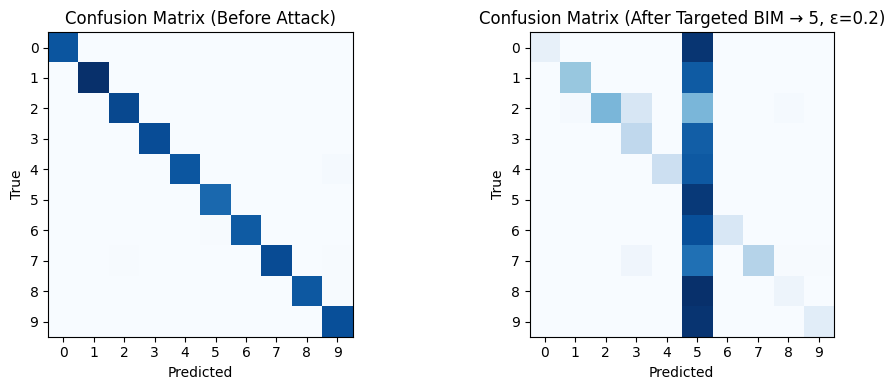

Accuracy before attack: 99.00%
Accuracy after  attack: 27.71%


In [6]:
# %% Targeted BIM attack -> build `rows` -> save -> plot gradient surfaces (2 columns)
# --------------------
# Config
# --------------------
TARGET_CLASS    = 5
epsilon_pixel   = 0.2          # ε in [0,1] pixel space
eps_iter_pixel  = 0.01         # step size in [0,1]
nb_iter         = 100          # BIM steps
MAX_VIS         = 10           # number of successful examples to cache for plots
N_PLOT_ROWS     = 5            # how many rows to display (<= MAX_VIS)

# scale to normalized [-1,1] space used by your loader
epsilon  = 2 * epsilon_pixel
eps_iter = 2 * eps_iter_pixel

# --------------------
# Wrap model for Foolbox
# --------------------
model.eval().to(device)
fmodel = fb.PyTorchModel(model, bounds=(-1.0, 1.0), device=device)

attack = fb.attacks.LinfBasicIterativeAttack(
    steps=nb_iter, abs_stepsize=eps_iter, random_start=False
)

# --------------------
# Run attack & collect results
# --------------------
y_true_all, y_pred_before_all, y_pred_after_all = [], [], []

vis_orig, vis_adv = [], []
vis_pred_before, vis_pred_after, vis_true = [], [], []

pbar = tqdm(test_loader, desc=f"BIM targeted→{TARGET_CLASS} (ε={epsilon_pixel}, steps={nb_iter})")
for images, labels in pbar:
    images, labels = images.to(device), labels.to(device)

    # predictions BEFORE attack
    with torch.no_grad():
        preds_before = model(images).argmax(1)

    # targeted criterion (all samples -> TARGET_CLASS)
    targets = torch.full_like(labels, fill_value=TARGET_CLASS)
    criterion = fb.criteria.TargetedMisclassification(targets)

    # run BIM
    advs, _, _ = attack(fmodel, images, epsilons=epsilon, criterion=criterion)

    # predictions AFTER attack
    with torch.no_grad():
        preds_after = model(advs).argmax(1)

    # collect confusion/accuracy data
    y_true_all.append(labels.detach().cpu())
    y_pred_before_all.append(preds_before.detach().cpu())
    y_pred_after_all.append(preds_after.detach().cpu())

    # cache up to MAX_VIS successful targeted examples: (orig != T) & (adv == T)
    mask = (preds_before != TARGET_CLASS) & (preds_after == TARGET_CLASS)
    idxs = torch.nonzero(mask, as_tuple=False).squeeze(-1).tolist()
    if isinstance(idxs, int):
        idxs = [idxs]
    for idx in idxs:
        if len(vis_orig) >= MAX_VIS:
            break
        vis_orig.append(images[idx].detach().cpu())
        vis_adv.append(advs[idx].detach().cpu())
        vis_pred_before.append(int(preds_before[idx].item()))
        vis_pred_after.append(int(preds_after[idx].item()))
        vis_true.append(int(labels[idx].item()))
    if len(vis_orig) >= MAX_VIS:
        # still finish loop to compute full confusion, but you can break here if speed matters
        pass

# --------------------
# Build & save `rows`
# --------------------
rows = []
for i in range(len(vis_orig)):
    rows.append({
        "orig": vis_orig[i].unsqueeze(0),  # [1,1,28,28]
        "adv":  vis_adv[i].unsqueeze(0),   # [1,1,28,28]
        "pb":   vis_pred_before[i],        # prediction before
        "pa":   vis_pred_after[i],         # prediction after (target)
        "gt":   vis_true[i],               # ground truth
    })

os.makedirs("cache", exist_ok=True)
torch.save(rows, "cache/rows.pt")
print(f"Saved {len(rows)} rows to cache/rows.pt")

# --------------------
# Confusion matrices & accuracy (optional)
# --------------------
y_true        = torch.cat(y_true_all).numpy()
y_pred_before = torch.cat(y_pred_before_all).numpy()
y_pred_after  = torch.cat(y_pred_after_all).numpy()

cm_before = confusion_matrix(y_true, y_pred_before)
cm_after  = confusion_matrix(y_true, y_pred_after)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(cm_before, interpolation='nearest', cmap=plt.cm.Blues)
axs[0].set_xticks(range(10)); axs[0].set_yticks(range(10))
axs[0].set_xlabel('Predicted'); axs[0].set_ylabel('True')
axs[0].set_title('Confusion Matrix (Before Attack)')

axs[1].imshow(cm_after, interpolation='nearest', cmap=plt.cm.Blues)
axs[1].set_xticks(range(10)); axs[1].set_yticks(range(10))
axs[1].set_xlabel('Predicted'); axs[1].set_ylabel('True')
axs[1].set_title(f'Confusion Matrix (After Targeted BIM → {TARGET_CLASS}, ε={epsilon_pixel})')
plt.tight_layout()
plt.show()

acc_before = (y_pred_before == y_true).mean() * 100.0
acc_after  = (y_pred_after  == y_true).mean() * 100.0
print(f"Accuracy before attack: {acc_before:.2f}%")
print(f"Accuracy after  attack: {acc_after:.2f}%")



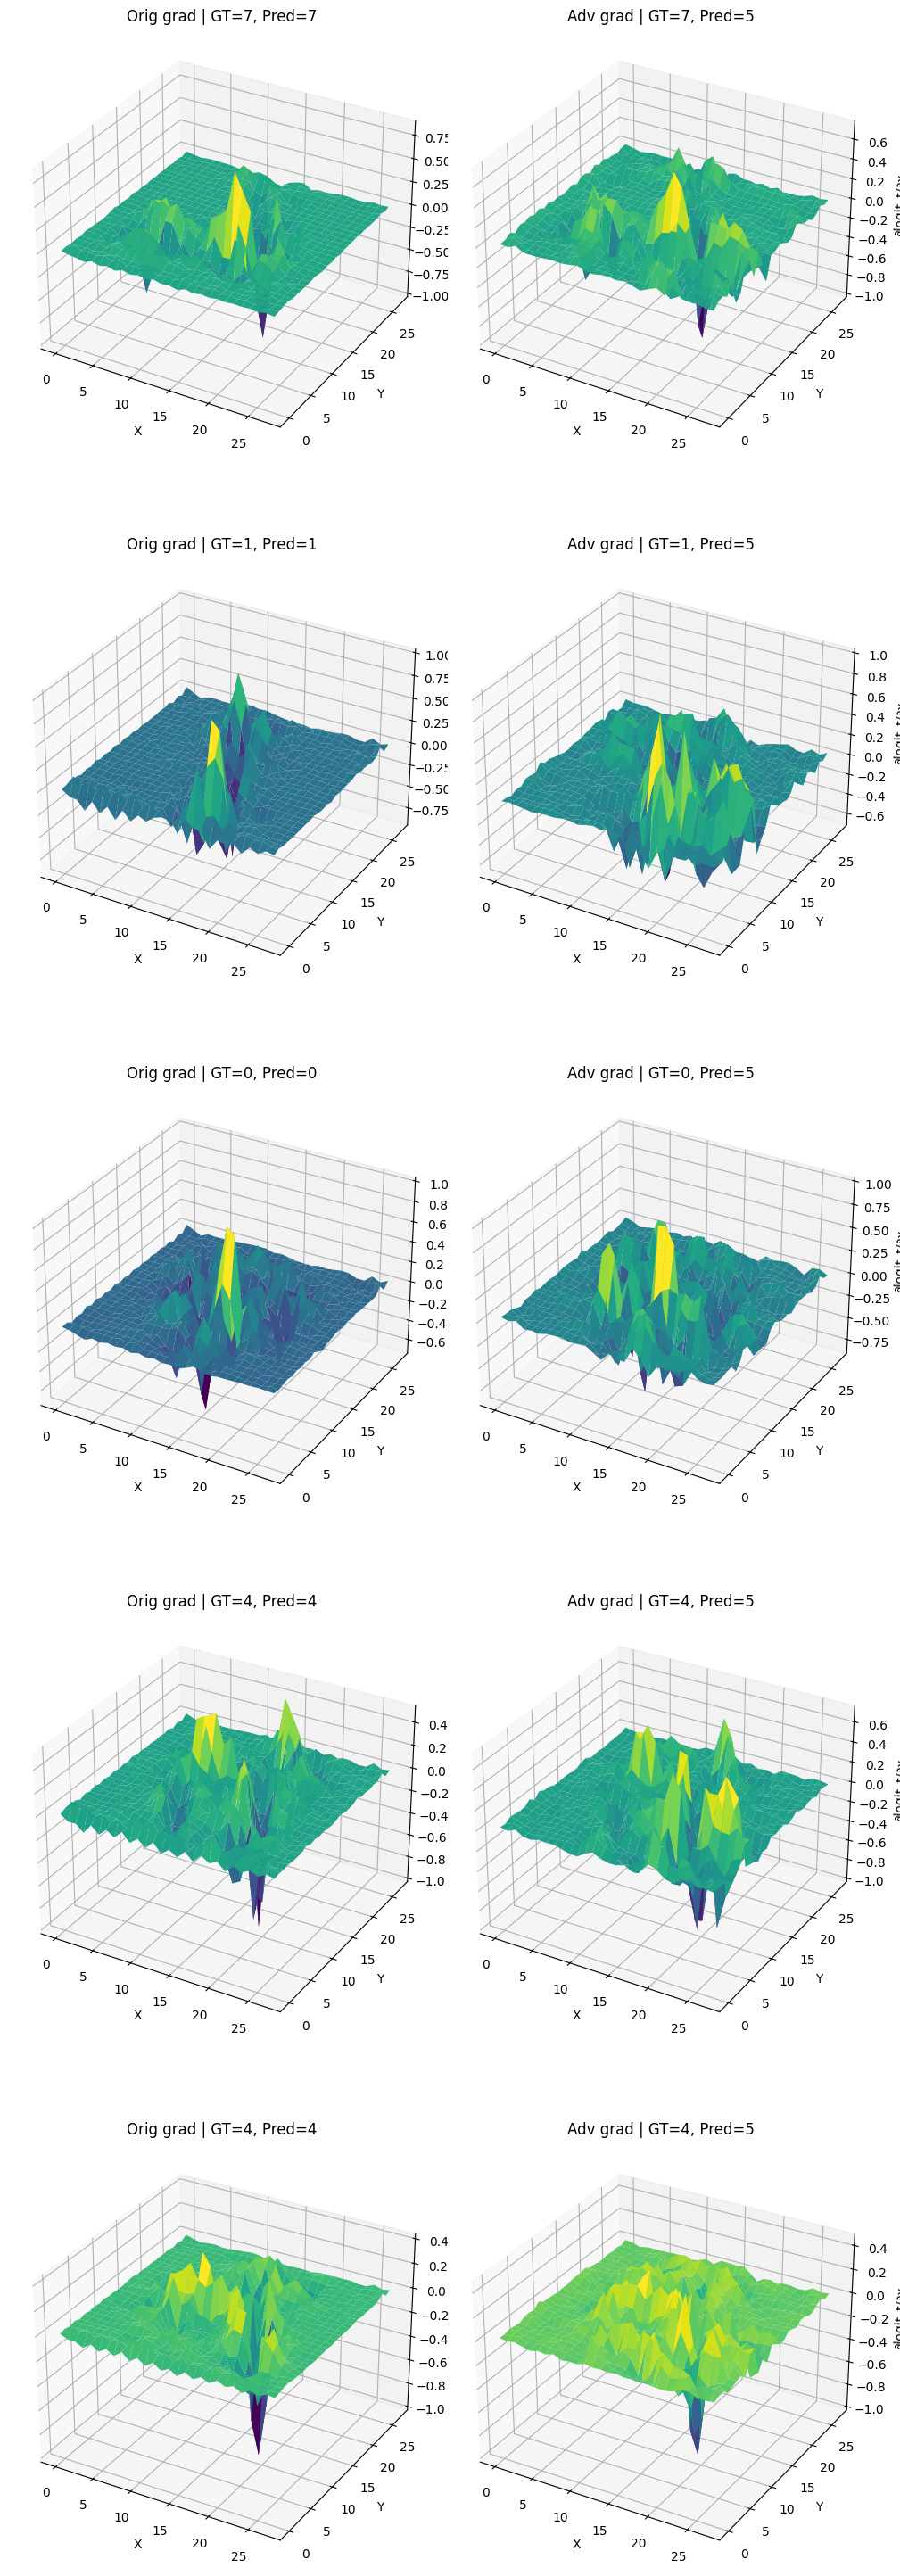

In [7]:
# --------------------
# Plot gradient surfaces (2 columns): original vs adversarial
# --------------------
# gradient wrt given class logit (single image [1,1,28,28])
def grad_wrt_class(single_img, class_idx):
    x = single_img.clone().detach().to(device).requires_grad_(True)
    logits = model(x)
    logit = logits[0, class_idx]
    model.zero_grad(set_to_none=True)
    if x.grad is not None:
        x.grad.zero_()
    logit.backward()
    return x.grad.detach()[0, 0].cpu()  # [28,28]

# meshgrid for 3D surfaces
X, Y = np.meshgrid(np.arange(28), np.arange(28))

n_rows = min(N_PLOT_ROWS, len(rows))
if n_rows == 0:
    print("No successful targeted examples cached; nothing to plot.")
else:
    fig = plt.figure(figsize=(2 * 5, n_rows * 6))  # 2 cols per row
    plot_idx = 1

    for k in range(n_rows):
        item = rows[k]
        orig = item["orig"]
        adv  = item["adv"]
        gt   = item["gt"]
        pb   = item["pb"]
        pa   = item["pa"]

        # gradients wrt TARGET_CLASS
        g_orig = grad_wrt_class(orig, TARGET_CLASS)
        g_adv  = grad_wrt_class(adv,  TARGET_CLASS)

        # normalize surfaces by max abs for display (keep sign)
        def norm_surface(Z):
            Z = Z.numpy()
            maxabs = np.max(np.abs(Z)) + 1e-12
            return Z / maxabs

        Z0 = norm_surface(g_orig)
        Z1 = norm_surface(g_adv)

        # 1) Original gradient surface
        ax = fig.add_subplot(n_rows, 2, plot_idx, projection='3d'); plot_idx += 1
        ax.plot_surface(X, Y, Z0, cmap='viridis', linewidth=0, antialiased=True)
        ax.set_title(f"Orig grad | GT={gt}, Pred={pb}")
        ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("∂logit_t/∂x")

        # 2) Adversarial gradient surface
        ax = fig.add_subplot(n_rows, 2, plot_idx, projection='3d'); plot_idx += 1
        ax.plot_surface(X, Y, Z1, cmap='viridis', linewidth=0, antialiased=True)
        ax.set_title(f"Adv grad | GT={gt}, Pred={pa}")
        ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("∂logit_t/∂x")

    plt.tight_layout()
    plt.show()


LinfMomentumIterativeAttack not found; using LinfPGD with same steps/step.


MIM targeted→5 (ε=0.2, steps=40):   0%|          | 0/40 [00:00<?, ?it/s]

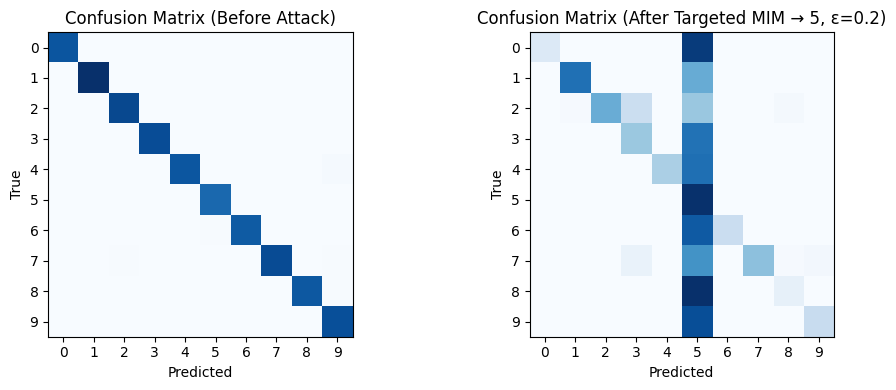

Accuracy before attack: 99.00%
Accuracy after  attack: 36.56% (ε=0.2, steps=40, step≈0.0075, decay=1.0)


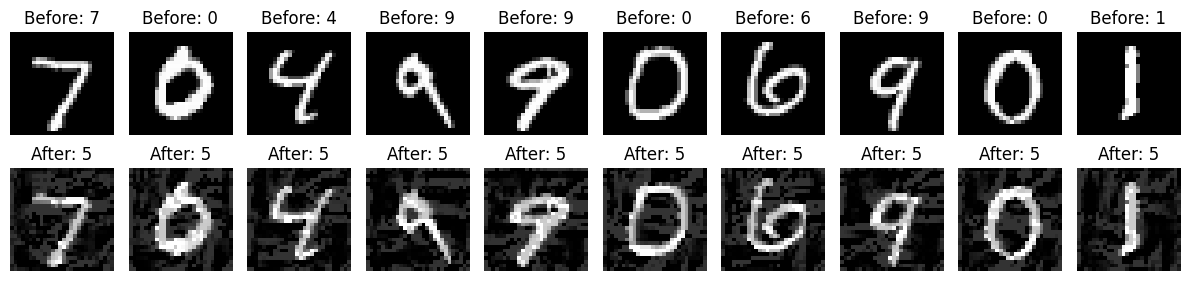

In [8]:
# ---- config (inputs are normalized to [-1,1]) ----
TARGET_CLASS = 5
epsilon_pixel  = 0.2                 # ε in [0,1] pixel space
epsilon        = 2 * epsilon_pixel   # scale for [-1,1]
steps          = 40                  # fewer steps than 100 -> much faster
step_pixel     = epsilon_pixel / steps * 1.5  # slightly larger step helps MIM
abs_stepsize   = 2 * step_pixel
decay_factor   = 1.0                 # momentum decay

model.eval().to(device)
fmodel = fb.PyTorchModel(model, bounds=(-1.0, 1.0), device=device)

# Use Momentum Iterative Attack (falls back to PGD if not available)
try:
    attack = fb.attacks.LinfMomentumIterativeAttack(
        steps=steps, abs_stepsize=abs_stepsize, decay=decay_factor, random_start=False
    )
except AttributeError:
    print("LinfMomentumIterativeAttack not found; using LinfPGD with same steps/step.")
    attack = fb.attacks.LinfProjectedGradientDescentAttack(
        steps=steps, abs_stepsize=abs_stepsize, random_start=False
    )

# --- accumulate per-batch (keeps lengths consistent) ---
y_true_all, y_pred_before_all, y_pred_after_all = [], [], []

vis_orig, vis_adv = [], []
vis_pred_before, vis_pred_after = [], []

pbar = tqdm(test_loader, desc=f"MIM targeted→{TARGET_CLASS} (ε={epsilon_pixel}, steps={steps})")
for images, labels in pbar:
    images, labels = images.to(device), labels.to(device)

    # predictions BEFORE attack
    with torch.no_grad():
        preds_before = model(images).argmax(1)

    # targeted criterion (all to TARGET_CLASS)
    targets = torch.full_like(labels, fill_value=TARGET_CLASS)
    criterion = fb.criteria.TargetedMisclassification(targets)

    # run MIM
    advs, _, _ = attack(fmodel, images, epsilons=epsilon, criterion=criterion)

    # predictions AFTER attack
    with torch.no_grad():
        preds_after = model(advs).argmax(1)

    # collect
    y_true_all.append(labels.detach().cpu())
    y_pred_before_all.append(preds_before.detach().cpu())
    y_pred_after_all.append(preds_after.detach().cpu())

    # cache up to 10 successful examples: (orig != T) & (adv == T)
    mask = (preds_before != TARGET_CLASS) & (preds_after == TARGET_CLASS)
    idxs = torch.nonzero(mask, as_tuple=False).squeeze(-1).tolist()
    if isinstance(idxs, int):
        idxs = [idxs]
    for idx in idxs:
        if len(vis_orig) >= 10:
            break
        vis_orig.append(images[idx].detach().cpu())
        vis_adv.append(advs[idx].detach().cpu())
        vis_pred_before.append(int(preds_before[idx].item()))
        vis_pred_after.append(int(preds_after[idx].item()))
    # show running success rate in tqdm
    total_so_far = sum(len(x) for x in y_true_all)
    succ_so_far = sum(((torch.cat(y_pred_after_all) == TARGET_CLASS).numpy()).tolist())
    pbar.set_postfix(succ_rate=f"{100*succ_so_far/total_so_far:.1f}%")

# --- stack & confusion matrices ---
y_true        = torch.cat(y_true_all).numpy()
y_pred_before = torch.cat(y_pred_before_all).numpy()
y_pred_after  = torch.cat(y_pred_after_all).numpy()

cm_before = confusion_matrix(y_true, y_pred_before)
cm_after  = confusion_matrix(y_true, y_pred_after)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(cm_before, interpolation='nearest', cmap=plt.cm.Blues)
axs[0].set_xticks(range(10)); axs[0].set_yticks(range(10))
axs[0].set_xlabel('Predicted'); axs[0].set_ylabel('True')
axs[0].set_title('Confusion Matrix (Before Attack)')

axs[1].imshow(cm_after, interpolation='nearest', cmap=plt.cm.Blues)
axs[1].set_xticks(range(10)); axs[1].set_yticks(range(10))
axs[1].set_xlabel('Predicted'); axs[1].set_ylabel('True')
axs[1].set_title(f'Confusion Matrix (After Targeted MIM → {TARGET_CLASS}, ε={epsilon_pixel})')
plt.tight_layout()
plt.show()

# --- accuracy before/after ---
acc_before = (y_pred_before == y_true).mean() * 100.0
acc_after  = (y_pred_after  == y_true).mean() * 100.0
print(f"Accuracy before attack: {acc_before:.2f}%")
print(f"Accuracy after  attack: {acc_after:.2f}% (ε={epsilon_pixel}, steps={steps}, step≈{step_pixel:.4f}, decay={decay_factor})")

# --- visualize 10 examples (original vs adversarial) ---
def denorm(img):   # inverse of Normalize((0.5,), (0.5,))
    return (img * 0.5 + 0.5).clamp(0, 1)

if len(vis_orig) > 0:
    vis_orig = torch.stack(vis_orig)[:10]
    vis_adv  = torch.stack(vis_adv)[:10]
    fig, axs = plt.subplots(2, 10, figsize=(12, 3))
    axs = axs.flatten()
    for i in range(len(vis_orig)):
        axs[i].imshow(denorm(vis_orig[i,0]).numpy(), cmap="gray")
        axs[i].set_title(f"Before: {vis_pred_before[i]}")
        axs[i].axis("off")
        axs[i+10].imshow(denorm(vis_adv[i,0]).numpy(), cmap="gray")
        axs[i+10].set_title(f"After: {vis_pred_after[i]}")
        axs[i+10].axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No successful targeted examples found for current parameters.")


Carlini-Wagner L2 attacks:   0%|          | 0/10 [00:00<?, ?it/s]

True: 3, Orig: 3, Adv: 3, L2=0.000
True: 8, Orig: 8, Adv: 3, L2=4.384
True: 0, Orig: 0, Adv: 3, L2=4.924
True: 6, Orig: 6, Adv: 3, L2=4.244
True: 0, Orig: 0, Adv: 3, L2=4.069
True: 3, Orig: 3, Adv: 3, L2=0.000
True: 7, Orig: 7, Adv: 3, L2=2.862
True: 5, Orig: 5, Adv: 3, L2=3.448
True: 5, Orig: 3, Adv: 3, L2=0.000
True: 7, Orig: 7, Adv: 3, L2=2.738

CW-L2 targeted to 3: 10/10 succeeded.
Median L2 (successful only): 3.155


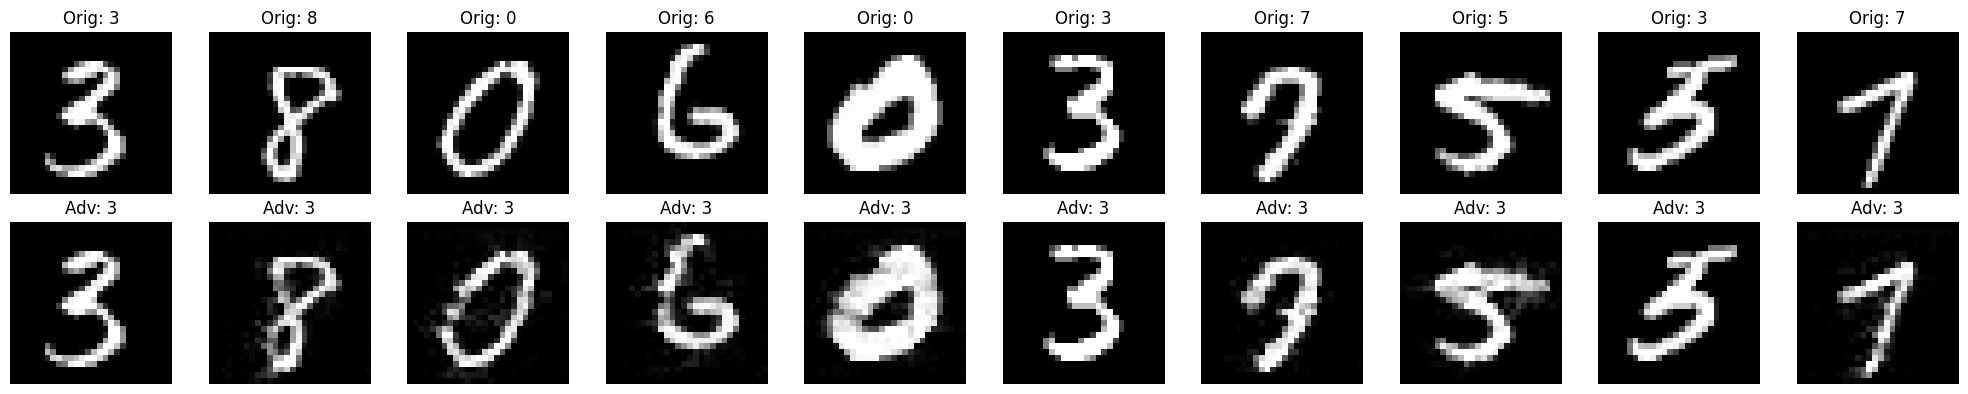

In [9]:
# ==============================================================================
# Carlini-Wagner L2 targeted attack with Foolbox + tqdm (fixed: epsilons=None)
# ==============================================================================
# ---- config ----
TARGET_CLASS   = 3
num_samples    = 10          # was 150; CW is heavy—bump up later if you want
max_iterations = 300         # was 1000; lower for speed
confidence     = 0.0         # 100.0 is very strong/slow; start small

model.eval().to(device)
fmodel = fb.PyTorchModel(model, bounds=(-1.0, 1.0), device=device)

attack = fb.attacks.L2CarliniWagnerAttack(steps=max_iterations, confidence=confidence)

adv_examples = []
rand_idx_list = []
adv_preds = []
org_preds = []
true_labels = []
l2_dists = []

for _ in tqdm(range(num_samples), desc="Carlini-Wagner L2 attacks"):
    # pick a random test sample
    rand_idx = np.random.randint(0, len(test_dataset))
    rand_idx_list.append(rand_idx)

    img, label = test_dataset[rand_idx]     # img: [1,28,28] in [-1,1]
    img = img.unsqueeze(0).to(device)       # [1,1,28,28]
    true_labels.append(int(label))

    # targeted criterion -> TARGET_CLASS
    target = torch.tensor([TARGET_CLASS], device=device)
    criterion = fb.criteria.TargetedMisclassification(target)

    # run CW-L2 (IMPORTANT: epsilons=None)
    advs, _, _ = attack(fmodel, img, criterion=criterion, epsilons=None)

    with torch.no_grad():
        pred_orig = model(img).argmax(1).cpu().item()
        pred_adv  = model(advs).argmax(1).cpu().item()

    # L2 distortion (in normalized space)
    l2 = torch.linalg.vector_norm((advs - img).view(1, -1), ord=2).cpu().item()

    org_preds.append(pred_orig)
    adv_preds.append(pred_adv)
    adv_examples.append(advs.detach().cpu()[0, 0].numpy())
    l2_dists.append(l2)

    print(f"True: {label}, Orig: {pred_orig}, Adv: {pred_adv}, L2={l2:.3f}")

# --- summary ---
successes = sum(1 for pa in adv_preds if pa == TARGET_CLASS)
print(f"\nCW-L2 targeted to {TARGET_CLASS}: {successes}/{num_samples} succeeded.")
if successes:
    print(f"Median L2 (successful only): {np.median([d for d, pa in zip(l2_dists, adv_preds) if pa == TARGET_CLASS]):.3f}")

# --- visualize a few examples ---
n_show = min(10, len(adv_examples))
fig, axs = plt.subplots(2, n_show, figsize=(n_show*2, 4))
for i in range(n_show):
    idx = rand_idx_list[i]
    orig_img, _ = test_dataset[idx]
    orig_img = (orig_img * 0.5 + 0.5).numpy()  # denorm to [0,1]

    axs[0, i].imshow(orig_img[0], cmap="gray")
    axs[0, i].set_title(f"Orig: {org_preds[i]}")
    axs[0, i].axis("off")

    axs[1, i].imshow(adv_examples[i], cmap="gray")
    axs[1, i].set_title(f"Adv: {adv_preds[i]}")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()


AdvTrain FGSM ε=0.2 (epoch 1/1):   0%|          | 0/422 [00:00<?, ?it/s]

AdvTrain PGD ε=0.2 (epoch 1/4):   0%|          | 0/422 [00:00<?, ?it/s]

AdvTrain PGD ε=0.2 (epoch 2/4):   0%|          | 0/422 [00:00<?, ?it/s]

AdvTrain PGD ε=0.2 (epoch 3/4):   0%|          | 0/422 [00:00<?, ?it/s]

AdvTrain PGD ε=0.2 (epoch 4/4):   0%|          | 0/422 [00:00<?, ?it/s]

Saved robust model state_dict to: models/mnist_cnn_advtrained.pth

Accuracy (%)
Original  | Clean: 99.00 | FGSM: 40.82 | PGD:  6.31
Robust    | Clean: 98.99 | FGSM: 94.61 | PGD: 92.22


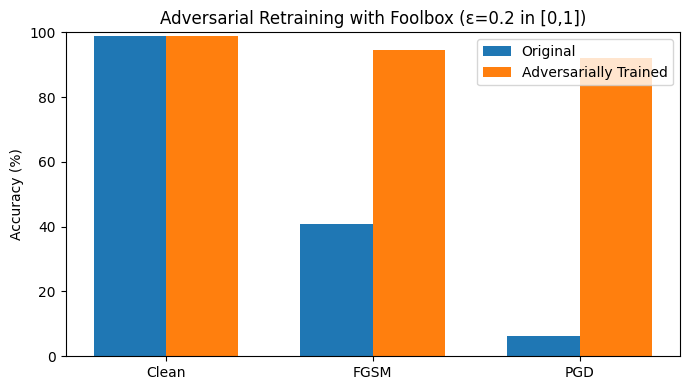

In [10]:
# %% Adversarial Retraining (Foolbox FGSM/PGD) + Evaluation + Plots
# -----------------------------
# Config (note the scaling)
# -----------------------------
# Your tensors are in [-1, 1]. If you think in pixel space [0,1], eps_pixel=0.2 -> eps=0.4 here.
eps_pixel_train = 0.2
eps_train = 2 * eps_pixel_train

# Training recipe: a couple of FGSM epochs then PGD epochs (all via Foolbox)
epochs_fgsm = 1
epochs_pgd  = 4

# PGD training hyperparams
pgd_steps_train     = 7
pgd_step_pixel      = eps_pixel_train / 4
pgd_abs_stepsize    = 2 * pgd_step_pixel        # scale to [-1,1]
pgd_random_start    = True

lr = 1e-3
save_path = "models/mnist_cnn_advtrained.pth"

# -----------------------------
# Build models
# -----------------------------
criterion = nn.CrossEntropyLoss()

# Original (frozen copy for eval)
original_model = SimpleCNN().to(device)
try:
    original_model.load_state_dict(model.state_dict())
except Exception:
    # If you don't have `model` in scope, try to load your baseline weights
    if os.path.exists("models/mnist_cnn.pth"):
        original_model.load_state_dict(torch.load("models/mnist_cnn.pth", map_location=device, weights_only=True))
original_model.eval()

# Robust model (to be trained)
robust_model = SimpleCNN().to(device)
try:
    robust_model.load_state_dict(original_model.state_dict())
except Exception:
    pass

optimizer = optim.Adam(robust_model.parameters(), lr=lr)

# -----------------------------
# Foolbox wrappers & attacks
# -----------------------------
def make_fmodel(m):
    m.eval().to(device)
    return fb.PyTorchModel(m, bounds=(-1.0, 1.0), device=device)

def fb_attack_inputs(attack, fmodel, x, y, eps):
    # Foolbox returns (advs, _, success). For scalar eps, advs may be a tensor or a list; normalize it.
    advs, _, _ = attack(fmodel, x, y, epsilons=eps)
    if isinstance(advs, (list, tuple)):
        advs = advs[0]
    return advs

# Training-time attacks
fgsm_train = fb.attacks.LinfFastGradientAttack()
pgd_train  = fb.attacks.LinfProjectedGradientDescentAttack(
    steps=pgd_steps_train, abs_stepsize=pgd_abs_stepsize, random_start=pgd_random_start
)

# Eval-time attacks (can be stronger)
fgsm_eval = fb.attacks.LinfFastGradientAttack()
pgd_eval  = fb.attacks.LinfProjectedGradientDescentAttack(
    steps=20, abs_stepsize=(eps_train/20)*1.5, random_start=True
)

# -----------------------------
# Adversarial training loop (Foolbox)
# -----------------------------
def adv_epoch(m, loader, attack, eps, desc):
    m.train()
    loop = tqdm(loader, desc=desc)
    total, correct, running_loss = 0, 0, 0.0
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        fmodel = make_fmodel(m)  # ensure wrapper sees current weights

        # Craft adversarial examples with Foolbox (UNTARGETED)
        adv = fb_attack_inputs(attack, fmodel, x, y, eps=eps)

        # Standard CE on adversarial batch
        optimizer.zero_grad(set_to_none=True)
        logits = m(adv)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += float(loss.item()) * x.size(0)
        total += y.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        loop.set_postfix(loss=f"{running_loss/total:.4f}", acc=f"{100*correct/total:.2f}%")

# FGSM epochs
for e in range(1, epochs_fgsm + 1):
    adv_epoch(robust_model, train_loader, fgsm_train, eps_train, desc=f"AdvTrain FGSM ε={eps_pixel_train} (epoch {e}/{epochs_fgsm})")

# PGD epochs
for e in range(1, epochs_pgd + 1):
    adv_epoch(robust_model, train_loader, pgd_train, eps_train, desc=f"AdvTrain PGD ε={eps_pixel_train} (epoch {e}/{epochs_pgd})")

# -----------------------------
# Save robust model (state_dict)
# -----------------------------
os.makedirs("models", exist_ok=True)
torch.save(robust_model.state_dict(), save_path)
print(f"Saved robust model state_dict to: {save_path}")

# -----------------------------
# Evaluation (Clean / FGSM / PGD) using Foolbox
# -----------------------------
@torch.no_grad()
def eval_clean(m, loader):
    m.eval()
    total, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = m(x).argmax(1)
        total += y.size(0)
        correct += (pred == y).sum().item()
    return 100.0 * correct / total

def eval_attack(m, loader, attack, eps):
    m.eval()
    fmodel = make_fmodel(m)
    total, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        adv = fb_attack_inputs(attack, fmodel, x, y, eps=eps)
        with torch.no_grad():
            pred = m(adv).argmax(1)
        total += y.size(0)
        correct += (pred == y).sum().item()
    return 100.0 * correct / total

# Evaluate original model
orig_clean = eval_clean(original_model, test_loader)
orig_fgsm  = eval_attack(original_model, test_loader, fgsm_eval, eps_train)
orig_pgd   = eval_attack(original_model, test_loader, pgd_eval,  eps_train)

# Evaluate robust model
rob_clean  = eval_clean(robust_model, test_loader)
rob_fgsm   = eval_attack(robust_model,  test_loader, fgsm_eval, eps_train)
rob_pgd    = eval_attack(robust_model,  test_loader, pgd_eval,  eps_train)

print("\nAccuracy (%)")
print(f"Original  | Clean: {orig_clean:5.2f} | FGSM: {orig_fgsm:5.2f} | PGD: {orig_pgd:5.2f}")
print(f"Robust    | Clean: {rob_clean:5.2f} | FGSM: {rob_fgsm:5.2f} | PGD: {rob_pgd:5.2f}")

# -----------------------------
# Plot comparison
# -----------------------------
labels = ["Clean", "FGSM", "PGD"]
orig_vals = [orig_clean, orig_fgsm, orig_pgd]
rob_vals  = [rob_clean,  rob_fgsm,  rob_pgd]

x = np.arange(len(labels))
w = 0.35
plt.figure(figsize=(7,4))
plt.bar(x - w/2, orig_vals, width=w, label="Original")
plt.bar(x + w/2, rob_vals,  width=w, label="Adversarially Trained")
plt.xticks(x, labels)
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title(f"Adversarial Retraining with Foolbox (ε={eps_pixel_train} in [0,1])")
plt.legend()
plt.tight_layout()
plt.show()


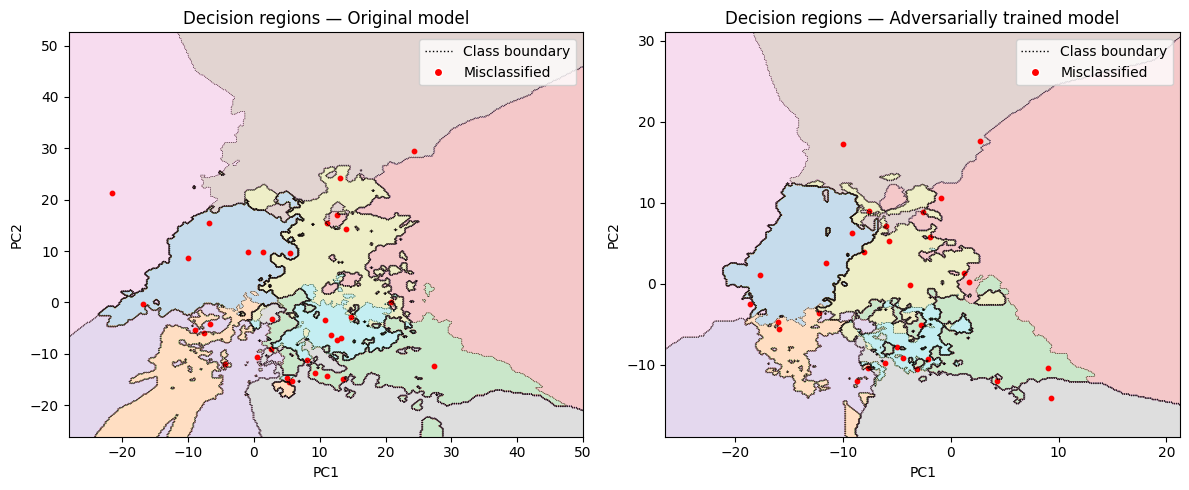

In [11]:
# %% Decision boundaries — show ONLY incorrect predictions + class boundary legend
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

# ---------------------------
# Ensure models exist (no training here)
# ---------------------------
def ensure_model(varname, fallback_path=None):
    m = globals().get(varname, None)
    if m is not None:
        return m
    if fallback_path and os.path.exists(fallback_path):
        m = SimpleCNN().to(device)
        state = torch.load(fallback_path, map_location=device, weights_only=True)
        m.load_state_dict(state); m.eval()
        print(f"Loaded {varname} from {fallback_path}")
        return m
    raise RuntimeError(f"{varname} is not defined and fallback load failed.")

original_model = ensure_model("original_model", "models/mnist_cnn.pth")
robust_model   = ensure_model("robust_model",   "models/mnist_cnn_advtrained.pth")
original_model.eval().to(device)
robust_model.eval().to(device)

# ---------------------------
# Feature extraction: penultimate layer
# ---------------------------
def penultimate_features(model, x):
    with torch.no_grad():
        feats = model.net[:-1](x)    # everything except final Linear
    return feats

# ---------------------------
# Collect subset of test data
# ---------------------------
max_samples = 2000
xs, ys = [], []
count = 0
for images, labels in test_loader:
    xs.append(images); ys.append(labels)
    count += images.size(0)
    if count >= max_samples:
        break
X = torch.cat(xs, dim=0)[:max_samples].to(device)
Y = torch.cat(ys, dim=0)[:max_samples].to(device)

# ---------------------------
# Get features & predictions
# ---------------------------
with torch.no_grad():
    logits_orig = original_model(X)
    preds_orig  = logits_orig.argmax(1)
    feats_orig  = penultimate_features(original_model, X)

    logits_rob = robust_model(X)
    preds_rob  = logits_rob.argmax(1)
    feats_rob  = penultimate_features(robust_model, X)

Y_np = Y.cpu().numpy()
preds_orig_np = preds_orig.cpu().numpy()
preds_rob_np  = preds_rob.cpu().numpy()

# ---------------------------
# PCA to 2D (shared space)
# ---------------------------
feats_all = torch.cat([feats_orig, feats_rob], dim=0).cpu().numpy()
pca = PCA(n_components=2, random_state=0).fit(feats_all)

Z_orig_2d = pca.transform(feats_orig.cpu().numpy())
Z_rob_2d  = pca.transform(feats_rob.cpu().numpy())

# ---------------------------
# Fit 2D kNN to draw boundaries (labels = model predictions)
# ---------------------------
knn_k = 5
knn_orig = KNeighborsClassifier(n_neighbors=knn_k).fit(Z_orig_2d, preds_orig_np)
knn_rob  = KNeighborsClassifier(n_neighbors=knn_k).fit(Z_rob_2d,  preds_rob_np)

def grid_for(Z):
    pad = 0.5
    x_min, x_max = Z[:,0].min() - pad, Z[:,0].max() + pad
    y_min, y_max = Z[:,1].min() - pad, Z[:,1].max() + pad
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    return xx, yy

xx_o, yy_o = grid_for(Z_orig_2d)
xx_r, yy_r = grid_for(Z_rob_2d)

grid_o = np.c_[xx_o.ravel(), yy_o.ravel()]
grid_r = np.c_[xx_r.ravel(), yy_r.ravel()]

Zpred_o = knn_orig.predict(grid_o).reshape(xx_o.shape)
Zpred_r = knn_rob.predict(grid_r).reshape(xx_r.shape)

# ---------------------------
# Plot (only wrong points) + explicit class boundaries
# ---------------------------
cmap10 = ListedColormap(plt.cm.tab10(np.linspace(0,1,10)))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Masks for incorrect predictions
mask_orig_wrong = preds_orig_np != Y_np
mask_rob_wrong  = preds_rob_np  != Y_np

# Legend proxies
boundary_proxy = Line2D([0],[0], color='k', linestyle=':', linewidth=1, label='Class boundary')
wrong_proxy    = Line2D([0],[0], marker='o', color='w', markerfacecolor='red', markersize=6,
                        linestyle='None', label='Misclassified')

# Original model
axs[0].contourf(xx_o, yy_o, Zpred_o, alpha=0.25, cmap=cmap10, levels=np.arange(-0.5,10.5,1))
# boundary lines (thin black contours at class transitions)
axs[0].contour(xx_o, yy_o, Zpred_o, levels=np.arange(-0.5,10.5,1), colors='k', linewidths=0.5, linestyles=':')
# only wrong points
axs[0].scatter(Z_orig_2d[mask_orig_wrong,0], Z_orig_2d[mask_orig_wrong,1],
               c="red", s=10)
axs[0].set_title("Decision regions — Original model")
axs[0].set_xlabel("PC1"); axs[0].set_ylabel("PC2")
axs[0].legend(handles=[boundary_proxy, wrong_proxy], loc="best")

# Robust model
axs[1].contourf(xx_r, yy_r, Zpred_r, alpha=0.25, cmap=cmap10, levels=np.arange(-0.5,10.5,1))
axs[1].contour(xx_r, yy_r, Zpred_r, levels=np.arange(-0.5,10.5,1), colors='k', linewidths=0.5, linestyles=':')
axs[1].scatter(Z_rob_2d[mask_rob_wrong,0], Z_rob_2d[mask_rob_wrong,1],
               c="red", s=10)
axs[1].set_title("Decision regions — Adversarially trained model")
axs[1].set_xlabel("PC1"); axs[1].set_ylabel("PC2")
axs[1].legend(handles=[boundary_proxy, wrong_proxy], loc="best")

plt.tight_layout()
plt.show()


In [12]:
# %% TRADES-robust teacher + adversarial distillation into SmallCNN + eval (FGSM/PGD/AA) + plot



# =========================================================
# Config
# =========================================================
# Data normalized to [-1,1] (Normalize((0.5,), (0.5,)))
eps_pixel = 0.3                       # classic MNIST robustness radius in [0,1]
eps       = 2 * eps_pixel             # convert to [-1,1]
pgd_steps_train   = 10
pgd_step          = eps / pgd_steps_train * 1.5
trades_beta       = 6.0               # strength of robustness regularization
epochs_trades     = 5                 # increase (10–20) for stronger robustness
lr_trades         = 1e-3

# Distillation
T_distill = 20.0
alpha     = 0.2                       # weight on hard CE during distillation
epochs_distill   = 5
lr_distill       = 1e-3
adv_distill      = True               # adversarial distillation (recommended)

# Eval PGD
pgd_eval_steps   = 40
pgd_eval_step    = eps / pgd_eval_steps * 1.5

# Checkpoint paths
os.makedirs("models", exist_ok=True)
ckpt_trades_teacher = "models/mnist_cnn_trades_teacher.pth"
ckpt_distilled      = "models/mnist_cnn_trades_distilled_small.pth"

# =========================================================
# Student model (smaller than teacher)
# =========================================================
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),      # 28->14
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),     # 14->7
            nn.Flatten(),
            nn.Linear(32*7*7, 64), nn.ReLU(),
            nn.Linear(64, 10)
        )
    def forward(self, x): return self.net(x)

# =========================================================
# Utility: ensure baseline/original model for comparison
# =========================================================
def get_original_model():
    # prefer an in-memory baseline
    if "original_model" in globals() and isinstance(original_model, nn.Module):
        m = SimpleCNN().to(device)
        m.load_state_dict(original_model.state_dict()); m.eval()
        return m
    if "model" in globals() and isinstance(model, nn.Module):
        m = SimpleCNN().to(device)
        try: m.load_state_dict(model.state_dict()); m.eval(); return m
        except: pass
    # fallback to disk
    m = SimpleCNN().to(device)
    p = "models/mnist_cnn.pth"
    if os.path.exists(p):
        state = torch.load(p, map_location=device, weights_only=True)
        m.load_state_dict(state)
    else:
        print("Warning: baseline weights not found; Original will be randomly initialized.")
    return m.eval()

original = get_original_model()

# =========================================================
# TRADES inner maximization: PGD on KL(p(x)||p(x_adv))
# =========================================================
def trades_pgd_kl(model, x, steps, step_size, eps):
    model.eval()
    x = x.detach()
    with torch.no_grad():
        p_clean = torch.softmax(model(x), dim=1)  # p(x)
    # random start
    x_adv = (x + torch.empty_like(x).uniform_(-eps, eps)).clamp(-1.0, 1.0)
    for _ in range(steps):
        x_adv.requires_grad_(True)
        logits_adv = model(x_adv)
        log_p_adv  = torch.log_softmax(logits_adv, dim=1)
        # KL(p_clean || p_adv) = sum p_clean * (log p_clean - log p_adv)
        loss_kl = nn.KLDivLoss(reduction="batchmean")(log_p_adv, p_clean)
        # maximize KL -> gradient ascent
        grad, = torch.autograd.grad(loss_kl, x_adv, retain_graph=False, create_graph=False)
        with torch.no_grad():
            x_adv = x_adv + step_size * grad.sign()
            # project to Linf ball around x
            x_adv = torch.max(torch.min(x_adv, x + eps), x - eps)
            x_adv = x_adv.clamp(-1.0, 1.0)
    return x_adv.detach()

# =========================================================
# Train TRADES teacher
# =========================================================
teacher = SimpleCNN().to(device)
try:
    # warm start from baseline if available
    teacher.load_state_dict(original.state_dict())
except Exception:
    pass

opt_t  = optim.Adam(teacher.parameters(), lr=lr_trades)
ce     = nn.CrossEntropyLoss()

for epoch in range(1, epochs_trades + 1):
    teacher.train()
    loop = tqdm(train_loader, desc=f"TRADES Teacher {epoch}/{epochs_trades}")
    run, tot, corr = 0.0, 0, 0
    for x, y in loop:
        x, y = x.to(device), y.to(device)

        # inner maximization: find x_adv maximizing KL
        x_adv = trades_pgd_kl(teacher, x, steps=pgd_steps_train, step_size=pgd_step, eps=eps)

        # TRADES objective: CE on clean + (1/beta)*KL(p(x)||p(x_adv))
        logits_clean = teacher(x)
        logits_adv   = teacher(x_adv)
        loss_nat = ce(logits_clean, y)
        p_clean  = torch.softmax(logits_clean.detach(), dim=1)
        log_p_adv = torch.log_softmax(logits_adv, dim=1)
        loss_rob = nn.KLDivLoss(reduction="batchmean")(log_p_adv, p_clean)

        loss = loss_nat + (1.0 / trades_beta) * loss_rob

        opt_t.zero_grad(set_to_none=True)
        loss.backward()
        opt_t.step()

        with torch.no_grad():
            tot += y.size(0)
            corr += (logits_clean.argmax(1) == y).sum().item()
            run  += float(loss.item()) * x.size(0)
        loop.set_postfix(loss=f"{run/tot:.4f}", acc=f"{100*corr/tot:.2f}%")

# save teacher
torch.save(teacher.state_dict(), ckpt_trades_teacher)
teacher.eval()
print(f"Saved TRADES teacher → {ckpt_trades_teacher}")

# =========================================================
# Distill robust teacher → SmallCNN student (optionally adversarial)
# =========================================================
student = SmallCNN().to(device)
# warm start (optional helps convergence)
try:
    partial = teacher.state_dict()
    student.state_dict().update({k:v for k,v in partial.items() if k in student.state_dict()})
    student.load_state_dict(student.state_dict())
except Exception:
    pass

opt_s = optim.Adam(student.parameters(), lr=lr_distill)

def distill_epoch(student, teacher, loader, adv=False):
    student.train(); teacher.eval()
    loop = tqdm(loader, desc=f"Distill(T={T_distill}, adv={adv})")
    run, tot, corr = 0.0, 0, 0
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        x_used = x

        if adv:
            # adversarial examples wrt student (standard CE PGD)
            fmodel_s = fb.PyTorchModel(student.eval().to(device), bounds=(-1,1), device=device)
            pgd_train = fb.attacks.LinfProjectedGradientDescentAttack(
                steps=pgd_steps_train, abs_stepsize=pgd_step, random_start=True
            )
            adv_batch, _, _ = pgd_train(fmodel_s, x, y, epsilons=eps)
            x_used = adv_batch.detach()

        with torch.no_grad():
            t_probs = torch.softmax(teacher(x_used) / T_distill, dim=1)

        logits_s = student(x_used)
        loss_hard = ce(logits_s, y)
        loss_soft = (T_distill*T_distill) * nn.KLDivLoss(reduction="batchmean")(
            torch.log_softmax(logits_s / T_distill, dim=1), t_probs
        )
        loss = alpha * loss_hard + (1 - alpha) * loss_soft

        opt_s.zero_grad(set_to_none=True)
        loss.backward()
        opt_s.step()

        with torch.no_grad():
            tot += y.size(0)
            corr += (logits_s.argmax(1) == y).sum().item()
            run  += float(loss.item()) * x.size(0)
        loop.set_postfix(loss=f"{run/tot:.4f}", acc=f"{100*corr/tot:.2f}%")

for epoch in range(1, epochs_distill + 1):
    distill_epoch(student, teacher, train_loader, adv=adv_distill)

torch.save(student.state_dict(), ckpt_distilled)
student.eval()
print(f"Saved distilled student → {ckpt_distilled}")



TRADES Teacher 1/5:   0%|          | 0/422 [00:00<?, ?it/s]

TRADES Teacher 2/5:   0%|          | 0/422 [00:00<?, ?it/s]

TRADES Teacher 3/5:   0%|          | 0/422 [00:00<?, ?it/s]

TRADES Teacher 4/5:   0%|          | 0/422 [00:00<?, ?it/s]

TRADES Teacher 5/5:   0%|          | 0/422 [00:00<?, ?it/s]

Saved TRADES teacher → models/mnist_cnn_trades_teacher.pth


Distill(T=20.0, adv=True):   0%|          | 0/422 [00:00<?, ?it/s]

Distill(T=20.0, adv=True):   0%|          | 0/422 [00:00<?, ?it/s]

Distill(T=20.0, adv=True):   0%|          | 0/422 [00:00<?, ?it/s]

Distill(T=20.0, adv=True):   0%|          | 0/422 [00:00<?, ?it/s]

Distill(T=20.0, adv=True):   0%|          | 0/422 [00:00<?, ?it/s]

Saved distilled student → models/mnist_cnn_trades_distilled_small.pth



Accuracy (%)
Original | Clean: 99.00 | FGSM:  9.28 | PGD:  0.00
TRADES   | Clean: 98.97 | FGSM: 91.10 | PGD: 77.87
Student  | Clean: 97.19 | FGSM: 90.36 | PGD: 85.71
AutoAttack not available or failed (No module named 'autoattack'). Skipping AA.


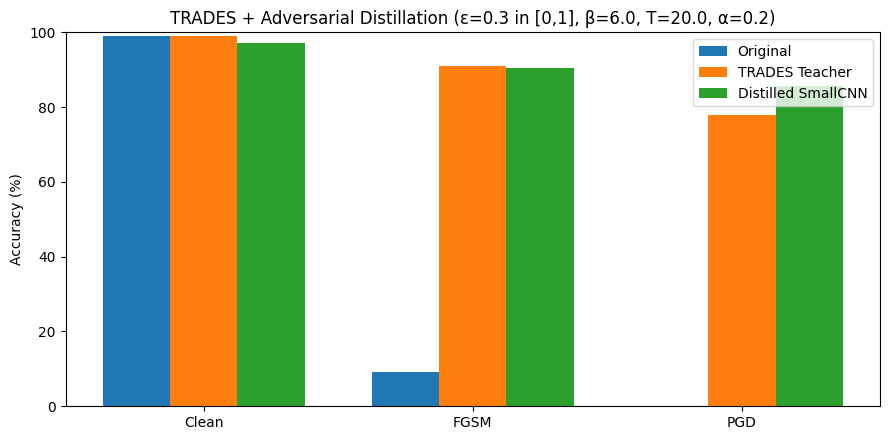

In [13]:
# =========================================================
# Evaluation: Clean / FGSM / PGD (Foolbox) + AutoAttack (if available)
# =========================================================
@torch.no_grad()
def eval_clean(m, loader):
    m.eval()
    tot, corr = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = m(x).argmax(1)
        tot += y.size(0); corr += (pred == y).sum().item()
    return 100.0 * corr / tot

def eval_attack(m, loader, attack, eps):
    m.eval()
    fmodel = fb.PyTorchModel(m, bounds=(-1,1), device=device)
    tot, corr = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        adv, _, _ = attack(fmodel, x, y, epsilons=eps)
        with torch.no_grad():
            pred = m(adv).argmax(1)
        tot += y.size(0); corr += (pred == y).sum().item()
    return 100.0 * corr / tot

fgsm = fb.attacks.LinfFastGradientAttack()
pgd  = fb.attacks.LinfProjectedGradientDescentAttack(steps=pgd_eval_steps,
                                                     abs_stepsize=pgd_eval_step,
                                                     random_start=True)

def try_autoattack_acc(m, loader, eps):
    try:
        from autoattack import AutoAttack
        m.eval()
        # gather the whole test set (be careful with RAM)
        Xs, Ys = [], []
        for x, y in loader:
            Xs.append(x); Ys.append(y)
        X = torch.cat(Xs, 0).to(device)
        Y = torch.cat(Ys, 0).to(device)
        # AA expects [0,1] by default; but our model takes [-1,1].
        # We'll wrap a lambda that rescales 0..1 -> -1..1 for eval OR
        # simply rescale inputs back to [-1,1] before feeding to model.
        # Instead, convert X to [0,1] for AA, and define a wrapper model that rescales.
        class Wrap(nn.Module):
            def __init__(self, base): 
                super().__init__(); self.base = base
            def forward(self, x01):
                # x01 in [0,1]; convert to [-1,1]
                x = x01*2 - 1
                return self.base(x)
        wrapped = Wrap(m).to(device)
        adversary = AutoAttack(wrapped, norm='Linf', eps=eps/2, version='standard')  # eps/2 to convert [-1,1] -> [0,1]
        # Convert X from [-1,1] -> [0,1] for AA input
        X01 = (X + 1)/2
        adv = adversary.run_standard_evaluation(X01, Y, bs=256)
        with torch.no_grad():
            preds = m(X).argmax(1)  # clean preds (for alignment)
            # AA already prints its own accuracy; we skip recompute here
        return None  # not returning a scalar here; AA prints its results
    except Exception as e:
        print(f"AutoAttack not available or failed ({e}). Skipping AA.")
        return None

# Original
orig_clean = eval_clean(original, test_loader)
orig_fgsm  = eval_attack(original, test_loader, fgsm, eps)
orig_pgd   = eval_attack(original, test_loader, pgd,  eps)

# TRADES Teacher
teacher_clean = eval_clean(teacher, test_loader)
teacher_fgsm  = eval_attack(teacher, test_loader, fgsm, eps)
teacher_pgd   = eval_attack(teacher, test_loader, pgd,  eps)

# Distilled Student
student_clean = eval_clean(student, test_loader)
student_fgsm  = eval_attack(student, test_loader, fgsm, eps)
student_pgd   = eval_attack(student, test_loader, pgd,  eps)

print("\nAccuracy (%)")
print(f"Original | Clean: {orig_clean:5.2f} | FGSM: {orig_fgsm:5.2f} | PGD: {orig_pgd:5.2f}")
print(f"TRADES   | Clean: {teacher_clean:5.2f} | FGSM: {teacher_fgsm:5.2f} | PGD: {teacher_pgd:5.2f}")
print(f"Student  | Clean: {student_clean:5.2f} | FGSM: {student_fgsm:5.2f} | PGD: {student_pgd:5.2f}")

# Optional AutoAttack (prints its own metrics)
try_autoattack_acc(teacher, test_loader, eps=eps)  # robust teacher AA (optional)

# =========================================================
# Plot
# =========================================================
labels = ["Clean", "FGSM", "PGD"]
orig_vals    = [orig_clean,    orig_fgsm,    orig_pgd]
trades_vals  = [teacher_clean, teacher_fgsm, teacher_pgd]
student_vals = [student_clean, student_fgsm, student_pgd]

x = np.arange(len(labels))
w = 0.25
plt.figure(figsize=(9,4.5))
plt.bar(x - w, orig_vals,    width=w, label="Original")
plt.bar(x,     trades_vals,  width=w, label="TRADES Teacher")
plt.bar(x + w, student_vals, width=w, label="Distilled SmallCNN")
plt.xticks(x, labels)
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title(f"TRADES + Adversarial Distillation (ε={eps_pixel} in [0,1], β={trades_beta}, T={T_distill}, α={alpha})")
plt.legend()
plt.tight_layout()
plt.show()
